In [2]:
# Submarine melting Qsm under different icefront temperature and sill depths
import xarray as xr
import numpy as np
import os
import matplotlib.pyplot as plt

In [3]:
# Melting flux at ice front
def IFA(case_path, case_id):
    # Grid areas    
    Area = np.empty([90, 10])
    Area[:20,:] = 400
    Area[20:50,:] = 800
    Area[50:,:] = 1200

    file0 = xr.open_dataset(case_path + '/icefrntA_' + str(format(case_id,'03d')) + '.nc')
    t0 = 0
    #tn = 120
    # removed duplicated data caused by model restart
    file = file0.isel(T=~file0.get_index("T").duplicated())
    state = file.isel(Y=range(35,45), T=range(t0,len(file.T)))
    
    MR = state.icefrntA.isel(X=1).data.mean(0) # Melt rate at the icefront
    Qsm = (MR*Area).sum()/(24*3600)
    return Qsm

In [4]:
# Water temperature at ice front
def icefrntT(case_path, case_id):
    File1 = xr.open_dataset(case_path + '/state_' + str(format(case_id,'03d')) + '.nc')
    Grid = xr.open_dataset(case_path + '/grid_' + str(format(case_id,'03d')) + '.nc')  
    State = File1.isel(T=~File1.get_index("T").duplicated())
    
    # Confine to the range of fjord
    state = State.isel(X=range(260), Xp1=range(261), Y=range(35,45), T=range(1,len(State.T)))
    grid = Grid.isel(X=range(260), Xp1=range(261), Y=range(35,45))

    U = (state.U.data[:,:,:,1:] + state.U.data[:,:,:,:-1]) / 2 # Along-channel velocity
    
    drF = np.broadcast_to(grid.drF.data[np.newaxis, :, np.newaxis, np.newaxis], U.shape)
    dyF = np.broadcast_to(grid.dyF.data[np.newaxis, np.newaxis, :, :], U.shape)
    HFacC = np.broadcast_to(grid.HFacC.data[np.newaxis, :, :, :], U.shape)
    DA = drF * dyF * HFacC
   
    t0 = 0 # Starting time index
    da = DA[t0:,:,:,1].mean(axis=(0,2))
    Ti = state.Temp.data[t0:,:,:,1].mean(axis=(0,2))
    Ui = U[t0:,:,:,1].mean(axis=(0,2))
    
    Tvi = np.sum(Ti*da) / np.sum(da)
    return Tvi

In [5]:
path1 = '/work/oceans/wbao/MITgcm_results/iceplume/Qsg050hs'
path2 = '/work/oceans/wbao/MITgcm_results/iceplume/1_BaseCase' # Qsg=250
path3 = '/work/oceans/wbao/MITgcm_results/iceplume/Qsg500hs'

caseN = np.array([1,2,3,4,5,6])

Qsm1 = np.empty(len(caseN))
Tice1 = np.empty(len(caseN))

Qsm2 = np.empty(len(caseN))
Tice2 = np.empty(len(caseN))

Qsm3 = np.empty(len(caseN))
Tice3 = np.empty(len(caseN))

for i in range(len(caseN)):
    
    Qsm1[i] = IFA(path1, caseN[i])
    Tice1[i] = icefrntT(path1, caseN[i])
    
    Qsm2[i] = IFA(path2, caseN[i])
    Tice2[i] = icefrntT(path2, caseN[i])
    
    Qsm3[i] = IFA(path3, caseN[i])
    Tice3[i] = icefrntT(path3, caseN[i])

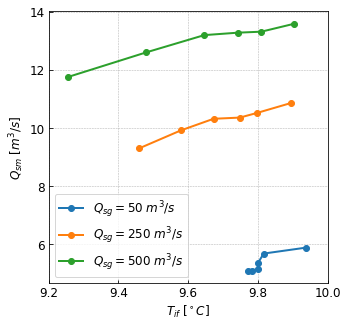

In [25]:
fig1, ax1 = plt.subplots(figsize=(5,5))
plt.grid(linestyle = '--', linewidth = 0.5)

#plt.axis('square')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel(r'$T_{if}\;[^\circ C]$', size=12)
plt.ylabel(r'$Q_{sm}\;[m^3/s]$',size=12)

ax1.plot(np.sort(Tice1), np.sort(Qsm1), 'o-', ms=6,lw=2,label=r'$Q_{sg}=50\;m^3/s$')
ax1.plot(np.sort(Tice2), np.sort(Qsm2), 'o-', ms=6,lw=2,label=r'$Q_{sg}=250\;m^3/s$')
ax1.plot(np.sort(Tice3), np.sort(Qsm3), 'o-', ms=6,lw=2,label=r'$Q_{sg}=500\;m^3/s$')
ax1.legend(loc='best', fontsize=12)
ax1.tick_params(direction='in', labelsize=12)
ax1.set_xlim([9.2, 10])

#ax1.set_xticks([0.04, 0.06, 0.08, 0.10, 0.12])
plt.show()

In [21]:
fig_path ="/home/1959/Jupyter_Figs/FjordModeling/"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)
fig1.savefig(fig_path + '/Qsm_Tif.png', dpi=200, bbox_inches='tight') 